In [1]:
import os
import glob
import json
import h5py
import copy

import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import cPickle as pkl
import matplotlib.gridspec as gridspec

from pipeline.python.classifications import utils as util
from pipeline.python.classifications import test_responsivity as resp
from pipeline.python.utils import label_figure, natural_keys, convert_range

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from matplotlib.patches import Ellipse, Rectangle

from shapely.geometry.point import Point
from shapely import affinity
from matplotlib.patches import Polygon

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

import matplotlib_venn as mpvenn
import itertools
%matplotlib notebook

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


In [2]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 


def create_ellipse(center, lengths, angle=0):
    """
    create a shapely ellipse. adapted from
    https://gis.stackexchange.com/a/243462
    """
    circ = Point(center).buffer(1)
    ell = affinity.scale(circ, int(lengths[0]), int(lengths[1]))
    ellr = affinity.rotate(ell, angle)
    return ellr

from shapely.geometry import box


def check_path_intersection(ref_patch, sample_patch, all_contained=False):
    ref_path = ref_patch.get_patch_transform().transform_path(ref_patch.get_path())

    verts = sample_patch.get_path().vertices
    trans = sample_patch.get_patch_transform()
    pts = trans.transform(verts)
    
    if all_contained:
        return all(g_path.contains_points(pts))
    else:
        return any(g_path.contains_points(pts))

In [40]:

def compare_rf_resolution(gdfs, animalid, session, fov, traceid='traces001'):
    '''
    Assumes trace_type = 'dff' and calculates using 'meanstim' stat metric.
    '''
    
    roi_lists = dict((exp, d.rois) for exp, d in gdfs.items())
    
    print("Found expmts for both RFs and RFs10")
    rf_set_labels = ['rfs', 'rfs10']
    rf_sets = [set(gdfs[k].rois) for k in rf_set_labels]
    
    ## Get distribution of RF sizes
    rfits, _ = util.get_receptive_field_fits(animalid, session, fov, traceid=traceid, run='combined_rfs_static')
    rfits10, _ = util.get_receptive_field_fits(animalid, session, fov, traceid=traceid, run='combined_rfs10_static')

    rfits_df = gdfs['rfs'].fits
    xres = list(set(np.diff(rfits['col_vals'])))[0]
    yres = list(set(np.diff(rfits['row_vals'])))[0]
    print("rfs: X- and Y-res: (%i, %i)" % (xres, yres))

    rfits_df10 =  gdfs['rfs10'].fits
    xres10 = list(set(np.diff(rfits10['col_vals'])))[0]
    yres10 = list(set(np.diff(rfits10['row_vals'])))[0]
    print("rfs10: X- and Y-res: (%i, %i)" % (xres10, yres10))

    rf_colors = {'rfs': 'red', 'rfs10': 'cornflowerblue'}
    sigma_scale = 2.36

    #fig, axes = pl.subplots(2,5, figsize=(10,4))
    fig = pl.figure(figsize=(10, 6))
    fig.patch.set_alpha(1)

    ## Venn diagram of overlap ROIs:
    ax = pl.subplot2grid((2, 5), (0, 0), colspan=1, rowspan=1)
    v = mpvenn.venn2(rf_sets, set_labels=rf_set_labels, ax=ax)
    for p in v.patches:
        p.set_alpha(0)
    c=mpvenn.venn2_circles(rf_sets, ax=ax) #set_labels=roi_set_labels, ax=ax)
    for ci in range(len(c)):
        c[ci].set_edgecolor(rf_colors[rf_set_labels[ci]])
        c[ci].set_alpha(0.5)

    ## Distribution of peak dF/Fs:
    ax = pl.subplot2grid((2, 5), (0, 1), colspan=2, rowspan=1)
    peak_dfs = [gdfs['rfs'].gdf.get_group(roi).groupby(['config']).mean()['meanstim'].max() for roi in roi_lists['rfs']]
    peak_dfs10 = [gdfs['rfs10'].gdf.get_group(roi).groupby(['config']).mean()['meanstim'].max() for roi in roi_lists['rfs10']]
    weights_rfs = np.ones_like(peak_dfs) / float(len(peak_dfs))
    sns.distplot(peak_dfs, ax=ax, color=rf_colors['rfs'], label='rfs (n=%i)' % len(peak_dfs),
                 kde=False, hist=True,
                 hist_kws={'histtype': 'step', 'alpha': 0.5, 'weights': weights_rfs, 'normed':0, 'lw': 2})
    weights_rfs10 = np.ones_like(peak_dfs10) / float(len(peak_dfs10))
    sns.distplot(peak_dfs10, ax=ax, color=rf_colors['rfs10'], label='rfs10 (n=%i)' % len(peak_dfs10),
                 kde=False, hist=True,
                 hist_kws={'histtype': 'step', 'alpha': 0.5, 'weights': weights_rfs10, 'normed':0, 'lw': 2})
    ax.legend(loc='upper right', fontsize=6)
    ax.set_xlim([0, ax.get_xlim()[-1]])
    ax.set_xlabel('peak dF/F')
    ax.set_ylabel('fraction')
    #ax.set_ylim([0, max([max(peak_dfs), max(peak_dfs10)])])
    sns.despine(trim=True, offset=2)

    ## Distribution of avg RF size:
    ax = pl.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=1)
    size_rfs = rfits_df[['sigma_x', 'sigma_y']].mean(axis=1)
    size_rfs10 = rfits_df10[['sigma_x', 'sigma_y']].mean(axis=1)
    weights_size_rfs = np.ones_like(size_rfs) / float(len(size_rfs))
    weights_size_rfs10 = np.ones_like(size_rfs10) / float(len(size_rfs10))
    sns.distplot(size_rfs, ax=ax, color=rf_colors['rfs'], label='rfs (avg. %.2f)' % np.mean(size_rfs),
                 kde=False, hist=True,
                 hist_kws={'histtype': 'step', 'alpha': 0.5, 'weights': weights_size_rfs, 'normed':0, 'lw': 2})
    sns.distplot(size_rfs10, ax=ax, color=rf_colors['rfs10'], label='rfs10 (avg. %.2f)' % np.mean(size_rfs10),
                 kde=False, hist=True,
                 hist_kws={'histtype': 'step', 'alpha': 0.5, 'weights': weights_size_rfs10, 'normed':0, 'lw': 2})
    ax.legend(loc='upper right', fontsize=6)
    ax.set_xlim([0, ax.get_xlim()[-1]+5])
    ax.set_xlabel('average RF size')
    ax.set_ylabel('fraction')
    sns.despine(trim=True, offset=2)



    ## Distribution of avg RF size:
    rois_in_both_rfs = intersection(rfits_df.index.tolist(), rfits_df10.index.tolist())
    rf_params=['sigma_x', 'sigma_y', 'x0', 'y0', 'theta']
    for ai in range(len(rf_params)):
        ax = pl.subplot2grid((2, 5), (1, ai), colspan=1, rowspan=1)
        ax.set_title(rf_params[ai])

        if rf_params[ai] == 'theta':
            rf_vals = [np.rad2deg(th) % 360. for th in rfits_df[rf_params[ai]][rois_in_both_rfs]]
            rf_vals10 = [np.rad2deg(th) % 360. for th in rfits_df10[rf_params[ai]][rois_in_both_rfs]]
        else:
            rf_vals = rfits_df[rf_params[ai]][rois_in_both_rfs]
            rf_vals10 = rfits_df10[rf_params[ai]][rois_in_both_rfs]
        ax.scatter(rf_vals, rf_vals10,
                   s=5, marker='o', c='k', alpha=0.5)
        ax.set_xlabel('rfs'); ax.set_ylabel('rfs10');
        minv = min([min(rf_vals), min(rf_vals10)])
        maxv = max([max(rf_vals), max(rf_vals10)])
        ax.set_xlim([minv, maxv])
        ax.set_ylim([minv, maxv])
        #sns.despine(trim=True, ax=ax)
        ax.set_aspect('equal')
    pl.subplots_adjust(wspace=1, hspace=.1, left=0.1)
    
    return fig


# Set data source

In [14]:
rootdir = '/n/coxfs01/2p-data'

animalid = 'JC085'
session = '20190622'
fov = 'FOV1_zoom2p0x'
traceid = 'traces001'


In [15]:
# Create output_dir

output_dir = os.path.join(rootdir, animalid, session, fov, 'summaries')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(output_dir)

/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/summaries


In [16]:
reload(util)

<module 'pipeline.python.classifications.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/utils.pyc'>

# Load data

In [17]:
trace_type = 'dff'

session_outfile = os.path.join(output_dir, 'sessiondata_%s_traces.pkl' % trace_type)
create_new = True

if os.path.exists(session_outfile) and create_new is False:
    print("loading session object...")
    with open(session_outfile, 'rb') as f:
        S = pkl.load(f)

else:
    print("creating new session object...")
    S = util.Session(animalid, session, fov, rootdir=rootdir)
    S.load_data(traceid=traceid, trace_type=trace_type)
    
    # Save session data object
    with open(session_outfile, 'wb') as f:
        pkl.dump(S, f, protocol=pkl.HIGHEST_PROTOCOL)

#print(S.experiments.keys())
data_identifier = '|'.join([S.animalid, S.session, S.fov, S.traceid, S.rois])
data_identifier
print(data_identifier)

creating new session object...
[JC085] 20190622 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... Loading all experiments (traces001 - dff)
('EXP:', ['rfs', 'rfs10', 'gratings', 'blobs', 'retino'])
-- rfs: got rois
 [JC085 | 20190622 | FOV1_zoom2p0x] creating experiment object - rfs
... getting data paths
... ... combined_rfs_static
... ... renaming experiment to run name: combined_rfs_static
-- rfs: got source
... loading data array (combined_rfs_static - datasets.npz)
... loaded
(198737, 6)
... making equal
incorrect reps / condn...
loaded
-- rfs10: got rois
 [JC085 | 20190622 | FOV1_zoom2p0x] creating experiment object - rfs10
... getting data paths
... ... combined_rfs10_static
... ... renaming experiment to run name: combined_rfs10_static
-- rfs10: got source
... loading data array (combined_rfs10_static - datasets.npz)
... loaded
(58740, 6)
... making equal
loaded
-- gratings: got rois
 [JC085 | 20190622 | FOV1_zoom2p0x] creating ex

In [7]:
S.experiments

{'blobs': <pipeline.python.classifications.utils.Experiment instance at 0x7f2f967b6878>,
 'gratings': <pipeline.python.classifications.utils.Experiment instance at 0x7f2f9733e2d8>,
 'rfs': <pipeline.python.classifications.utils.Experiment instance at 0x7f2f97338758>,
 'rfs10': <pipeline.python.classifications.utils.Experiment instance at 0x7f2f9679fea8>}

In [42]:
responsive_test = 'ROC'
stats_desc = '-'.join([traceid, trace_type, responsive_test])

statsdir = os.path.join(output_dir, 'stats')
if not os.path.exists(statsdir):
    os.makedirs(statsdir)
    
stats_fpath = os.path.join(statsdir, 'sessionstats_%s.pkl' % stats_desc)
print("Saving stats to file: %s" % stats_fpath)

statsfigdir = os.path.join(statsdir, 'figures')
if not os.path.exists(statsfigdir):
    os.makedirs(statsfigdir)

Saving stats to file: /n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/summaries/stats/sessionstats_traces001-dff-ROC.pkl


# Calculate stats using dff

In [19]:
mag_ratio_thr = 0.01
#rf_fit_thr = 0.5
gdfs = {}
for exp_name, exp in S.experiments.items():
    
    print("[%s] Loading roi lists..." % exp_name)
    
    estats = S.get_grouped_stats(exp_name, responsive_test=responsive_test, responsive_thr=mag_ratio_thr)
    
    gdfs.update(estats)


with open(stats_fpath, 'wb') as f:
    pkl.dump(gdfs, f, protocol=pkl.HIGHEST_PROTOCOL)

[rfs] Loading roi lists...
('Getting stats:', 'rfs')
('... getting grouped stats  for experiments: ', ['rfs'])
... [combined_rfs_static] Loading roi stats and cell list...
... loading event data
... loading RF fits: zscore0.00_no_trim
... loaded rf fits
... Found 80 responsive cells.
... loading data array (combined_rfs_static - datasets.npz)
... loaded
(198737, 6)
... making equal
incorrect reps / condn...
*** got rf fits***
[gratings] Loading roi lists...
('Getting stats:', 'gratings')
('... getting grouped stats  for experiments: ', ['gratings'])
... [combined_gratings_static] Loading roi stats and cell list...
... loading event data
... loading ROI stats: ROC
... Found 141 responsive cells.
... loading data array (combined_gratings_static - datasets.npz)
... loaded
(143360, 6)
... making equal
[rfs10] Loading roi lists...
('Getting stats:', 'rfs10')
('... getting grouped stats  for experiments: ', ['rfs10'])
... [combined_rfs10_static] Loading roi stats and cell list...
... loading

NameError: name 'sessionstats_fpath' is not defined

In [21]:
for exp_name, exp_gdf in gdfs.items():
    print('%s: %i rois' % (exp_name, len(exp_gdf.rois)))

rfs: 80 rois
gratings: 141 rois
rfs10: 110 rois
blobs: 169 rois


In [31]:
#roi_lists = dict((exp, d.rois) for exp, d in gdfs.items())

Found expmts for both RFs and RFs10
... loading RF fits: zscore0.00_no_trim
... loading RF fits: zscore0.00_no_trim
rfs: X- and Y-res: (5, 5)
rfs10: X- and Y-res: (10, 10)


<IPython.core.display.Javascript object>


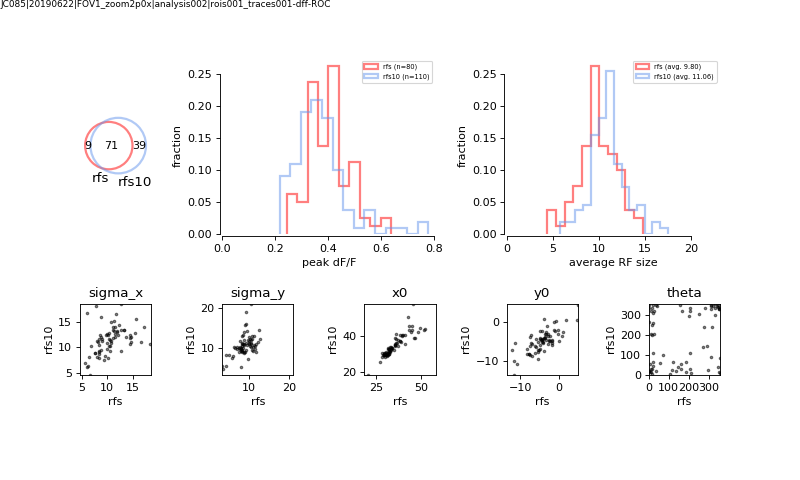

In [44]:
compare_rf_exps = False
if 'rfs' in gdfs.keys() and 'rfs10' in gdfs.keys():
    fig = compare_rf_resolution(gdfs, animalid, session, fov, traceid=traceid)
    
    label_figure(fig, '%s_%s' % (data_identifier, stats_desc))
    pl.savefig(os.path.join(statsfigdir, 'compare_rfs_vs_rfs10_%s.png' % stats_desc))

# Visualize responses to event-based experiments:

In [46]:
gdfs.keys()

['rfs', 'gratings', 'rfs10', 'blobs']

In [49]:
rf_exp_name = 'rfs10' if 'rfs10' in gdfs.keys() else 'rfs'

exp_names = sorted([rf_exp_name, 'gratings', 'blobs'])

tmp_roi_list = [v.rois for k, v in gdfs.items()]
all_rois = list(set(itertools.chain(*tmp_roi_list)))

#tmp_roi_list = [gdfs[k].rois for k in exp_names]
#event_rois = list(set(itertools.chain(*tmp_roi_list)))


exp_colors= {rf_exp_name: 'black',
            'gratings': 'orange',
             'blobs': 'blue'}
#              'retino': 'gray'}



['blobs', 'gratings', 'rfs10']


<IPython.core.display.Javascript object>


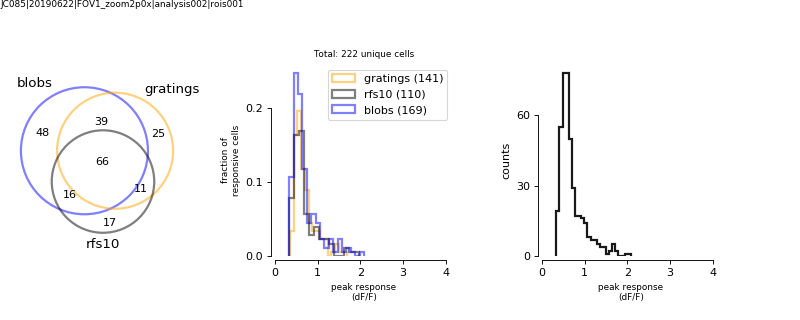

In [52]:
fig = compare_experiments_responsivity(gdfs, exp_names=exp_names, exp_colors=exp_colors)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(statsfigdir, "cell_counts_peak_w%s_%s.png" % (rf_exp_name, stats_desc)))


In [51]:

def compare_experiments_responsivity(gdfs, exp_names=[], exp_colors={}):

    tmp_roi_list = [gdfs[k].rois for k in exp_names]
    event_rois = list(set(itertools.chain(*tmp_roi_list)))

    roi_sets = [set(gdfs[k].rois) for k in exp_names]
    roi_set_labels = copy.copy(exp_names)
    print(roi_set_labels)

    fig, axes = pl.subplots(1,3, figsize=(10,4))
    fig.patch.set_alpha(1)

    ax = axes[0]
    v = mpvenn.venn3(roi_sets, set_labels=roi_set_labels, ax=ax)
    for pid in v.id2idx.keys():
        v.get_patch_by_id(pid).set_alpha(0)

    c=mpvenn.venn3_circles(roi_sets, ax=ax) #set_labels=roi_set_labels, ax=ax)
    for ci in range(len(c)):
        c[ci].set_edgecolor(exp_colors[roi_set_labels[ci]])
        c[ci].set_alpha(0.5)


    # Fraction of cells:
    ax = axes[1]
    for exp_name in exp_colors.keys():
        peak_values = gdfs[exp_name].gdf.max()['meanstim'].values
        weights = np.ones_like(peak_values) / float(len(event_rois))
        exp_str = '%s (%i)' % (exp_name, len(peak_values))
        sns.distplot(peak_values, label=exp_str, ax=ax, norm_hist=0, kde=False,
                     rug=False, rug_kws={"alpha": 0.5},
                     hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.5,
                             'weights': weights, 'normed': 0, "color": exp_colors[exp_name]})

    ax.set_xlabel('peak response\n(dF/F)', fontsize=8)
    ax.set_ylabel('fraction of\nresponsive cells', fontsize=8)
    ax.legend()
    ax.set_xlim([min([0, ax.get_xlim()[0]]), max([3, ax.get_xlim()[1]+2])])
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(3))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    sns.despine(trim=True, offset=4, ax=ax)
    ax.set_title('Total: %i unique cells' % len(event_rois), fontsize=8)

    # ALL responses -- counts of cells
    ax = axes[2]
    all_values = []
    for exp_name in exp_colors.keys():
        all_values.extend(gdfs[exp_name].gdf.max()['meanstim'].values)
    #weights = np.ones_like(all_values) / float(len(all_values))
    sns.distplot(all_values, ax=ax, norm_hist=0, kde=False,
                rug=False,
                hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.9, # 'weights': weights, 
                            'normed': 0, "color": 'k'}) #[ename]})
    ax.set_xlim([min([0, ax.get_xlim()[0]]), max([3, ax.get_xlim()[1]+2])])
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(3))
    sns.despine(trim=True, offset=4, ax=ax)
    ax.set_xlabel('peak response\n(dF/F)', fontsize=8)
    ax.set_ylabel('counts')

    pl.subplots_adjust(wspace=0.5, top=0.8, left=0.01, bottom=0.2)

    return fig